In [1]:
import pandas as pd 
import numpy as np

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import StandardScaler, MinMaxScaler 

import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

In [2]:
data1 = pd.read_csv('btc1.csv', sep=';').drop(columns=['<DATE>', '<TIME>'])
data2 = pd.read_csv('btc2.csv', sep=';').drop(columns=['<DATE>', '<TIME>'])
data3 = pd.read_csv('btc3.csv', sep=';').drop(columns=['<DATE>', '<TIME>'])
data4 = pd.read_csv('btc4.csv', sep=';').drop(columns=['<DATE>', '<TIME>'])
data5 = pd.read_csv('btc5.csv', sep=';').drop(columns=['<DATE>', '<TIME>'])
# data6 = pd.read_csv('BTC6.csv', sep=';').drop(columns=['<DATE>', '<TIME>'])
# data7 = pd.read_csv('BTC7.csv', sep=';').drop(columns=['<DATE>', '<TIME>'])
# data8 = pd.read_csv('BTC8.csv', sep=';').drop(columns=['<DATE>', '<TIME>'])

data = pd.concat([data1, data2, data3, data4, data5]).to_numpy()

# Проверка данных
print(data.shape)
print(type(data))

(1785, 5)
<class 'numpy.ndarray'>


In [3]:
CHANNEL_NAMES = ['Open', 'Max', 'Min', 'Close', 'Volume']
CHANNEL_INDEX = {name: chan for chan, name in enumerate(CHANNEL_NAMES)}

print(CHANNEL_INDEX)

{'Open': 0, 'Max': 1, 'Min': 2, 'Close': 3, 'Volume': 4}


In [4]:
CHANNEL_X = CHANNEL_NAMES                 
CHANNEL_Y = ['Close']               
SEQ_LEN = 4                              # Пришел к значению 24             
BATCH_SIZE = 40                           # Пришел к значению 10                
TEST_LEN = 40                           # Тестовая 3000
TRAIN_LEN = data.shape[0] - TEST_LEN 

In [5]:
chn_x = [CHANNEL_INDEX[c] for c in CHANNEL_X]
chn_y = [CHANNEL_INDEX[c] for c in CHANNEL_Y]

print(chn_x, chn_y)

[0, 1, 2, 3, 4] [3]


In [6]:
# Страховка от пересечения
data_train, data_test = data[:TRAIN_LEN], data[TRAIN_LEN + 4+SEQ_LEN:] # Сдвиг на 24 точки

# Отбор входных данных
x_data_train, x_data_test = data_train[:, chn_x], data_test[:, chn_x]

# Масштабирование данных
x_scaler = StandardScaler()
x_scaler.fit(x_data_train)
x_data_train = x_scaler.transform(x_data_train)
x_data_test = x_scaler.transform(x_data_test)

# Отбор выходных данных
y_data_train, y_data_test = data_train[:, chn_y], data_test[:, chn_y]

# Масштабирование данных
y_scaler = StandardScaler()
y_scaler.fit(y_data_train)
y_data_train = y_scaler.transform(y_data_train)
y_data_test = y_scaler.transform(y_data_test)

# Проверка формы данных
print(f'Train data: {x_data_train.shape}, {y_data_train.shape}')
print(f'Test  data: {x_data_test.shape}, {y_data_test.shape}')

Train data: (1745, 5), (1745, 1)
Test  data: (32, 5), (32, 1)


In [7]:
# Создание генератора для обучения
train_datagen = TimeseriesGenerator(x_data_train, 
                                    y_data_train,
                                    length=SEQ_LEN,
                                    stride=SEQ_LEN,
                                    sampling_rate=1,
                                    batch_size=BATCH_SIZE)

# Аналогичный генератор для валидации при обучении
val_datagen = TimeseriesGenerator(x_data_test, 
                                  y_data_test,
                                  length=SEQ_LEN,
                                  stride=SEQ_LEN,
                                  sampling_rate=1,
                                  batch_size=BATCH_SIZE)

# Проверка формы выдаваемого генератором результата
print(f'Train batch x: {train_datagen[0][0].shape}, y: {train_datagen[0][1].shape}')

Train batch x: (40, 4, 5), y: (40, 1)


In [8]:
# Один батч на всю выборку
test_datagen = TimeseriesGenerator(x_data_test, 
                                   y_data_test,
                                   length=SEQ_LEN,
                                   stride=SEQ_LEN,
                                   sampling_rate=1,
                                   batch_size=x_data_test.shape[0])

# Формирование тестовой выборки из генератора
x_test, y_test = test_datagen[0]

# Проверка формы тестовой выборки
print(f'Test x: {x_test.shape}, y: {y_test.shape}')

Test x: (7, 4, 5), y: (7, 1)


In [9]:
# Функция расчета результата предсказания сети

def get_pred(model,
             x_test, y_test,
             y_scaler): 

    # Вычисление и деномализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test))

    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled

In [10]:
# Функция расчета корреляции

def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]

In [11]:
# Функция визуализации результата предсказания 

def show_predict(y_pred, y_true,      # Прогноз данных и исходный ряд
                 start,               # Точка ряда, с которой начинается отрисовка графика
                 length,              # Количество точек для отрисовки графика
                 chn_list=None,       # Список каналов данных для отрисовки (по умолчанию все)
                 chn_names=CHANNEL_Y, # Список имен каналов данных
                 title=''):
  
    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    # Построение графика по всем каналам данных
    plt.figure(figsize=(22, 6))
    
    for chn in chn_list:
        plt.plot(y_pred[start:start + length, chn],
                label=f'{chn_names[chn]} Предсказание сети')
        plt.plot(y_true[start:start + length, chn], 
                label=f'{chn_names[chn]} Базовый ряд')

    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Данные')
    plt.legend()
    plt.show()

In [12]:
# Функция корреляций прогнозного ряда и исходного

def show_corr(y_pred, y_true,       # Прогноз данных и исходный ряд
              back_steps_max=5,    # Максимальное количество шагов смещения назад по времени
              chn_list=None,        # Список каналов данных для отрисовки (по умолчанию все)
              chn_names=CHANNEL_Y, 
              title=''):            # Список имен каналов данных
  
    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    y_len = y_true.shape[0]
    steps = range(0, back_steps_max + 1)

    # Построение графика по всем каналам данных
    plt.figure(figsize=(14, 7))

    for chn in chn_list:
        # Вычисление коэффициентов корреляции базового ряда и предсказания с разным смещением
        cross_corr = [correlate(y_true[:y_len - step, chn], y_pred[step:, chn]) for step in steps]

        # Вычисление коэффициентов автокорреляции базового ряда с разным смещением
        auto_corr = [correlate(y_true[:y_len - step, chn], y_true[step:, chn]) for step in steps]

        plt.plot(cross_corr, label=f'{chn_names[chn]} Предсказание сети')
        plt.plot(auto_corr, label=f'{chn_names[chn]} Эталонный показатель')

    plt.title(title)
    
    # Назначение меток шкалы оси x
    plt.xticks(steps)
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()

In [13]:
# Функция визуализации результата работы сети

def eval_net(model,                                  # Модель
             x_test, y_test,                         # Тестовая выборка
             y_scaler,                               # Нормирование выхода
             start=50, length=30,                    # Параметры отображения графиков
             back_steps_max=5,                      # Шаг смещения
             title=''):
  
    # Получение денормализованного предсказания и данных базового ряда
    y_pred, y_true = get_pred(model, x_test, y_test, y_scaler)
    
    # Отрисовка графика сопоставления базового и прогнозного рядов

    # Сдвиг прогнозного ряда на 1 шаг 
    show_predict(y_pred, y_true, start, length, 
                 title=f'{title}: Сопоставление базового и прогнозного рядов')
    
    # Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
    show_corr(y_pred, y_true, back_steps_max=back_steps_max, 
              title=f'{title}: Корреляционные коэффициенты по шагам смещения')

In [14]:
# Функция обучения модели и отрисовки прогресса 

def train_eval_net(model,                      # Модель
                   train_datagen, val_datagen, # Генераторы обучающей и проверочной выборок
                   epoch_list,                 # Список эпох
                   x_test, y_test, 
                   y_scaler, 
                   start=50, 
                   length=30, 
                   back_steps_max=5, 
                   title=''):
  
    # Обучение модели в несколько фаз
    for epochs, opt in epoch_list:
        # Компиляция модели
        model.compile(loss='mse', optimizer=opt)
        # Фаза обучения модели
        print(f'Обучение {epochs} эпох')
        history = model.fit(train_datagen, 
                            epochs=epochs, 
                            validation_data=val_datagen,
                            verbose=1)

        # Рисование графиков прошедшей фазы обучения
        fig = plt.figure(figsize=(14, 7))
        plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
        plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
        plt.title(f'{title}: График прогресса обучения')
        # Указание показывать только целые метки шкалы оси x
        fig.gca().xaxis.get_major_locator().set_params(integer=True)
        plt.xlabel('Эпоха обучения')
        plt.ylabel('Средняя ошибка')
        plt.legend()
        plt.show()

        # Рисование графиков оценки результата работы модели после фазы обучения
        eval_net(model, x_test, y_test, y_scaler, start=start, 
                 length=length, back_steps_max=back_steps_max, title=title)

In [15]:
# Собираю модель вручную - это первый вариант.
model_v1 = Sequential()
model_v1.add(Conv1D(1024, 1, input_shape=x_test.shape[1:], activation='linear'))
model_v1.add(Dense(16, activation='linear'))
model_v1.add(Flatten())
model_v1.add(Dense(8, activation='linear'))
model_v1.add(Dense(y_test.shape[1], activation='linear'))

model_v1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 1024)           6144      
                                                                 
 dense (Dense)               (None, 4, 16)             16400     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 23,073
Trainable params: 23,073
Non-trainable params: 0
_________________________________________________________________


Обучение 50 эпох
Epoch 1/50
11/11 [==============================] - 2s 28ms/step - loss: 1.1638 - val_loss: 0.0167
Epoch 2/50
11/11 [==============================] - 0s 6ms/step - loss: 0.2761 - val_loss: 0.0514
Epoch 3/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0210 - val_loss: 0.0599
Epoch 4/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0265 - val_loss: 0.0294
Epoch 5/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0137 - val_loss: 0.0108
Epoch 6/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0079 - val_loss: 0.0068
Epoch 7/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0084 - val_loss: 0.0067
Epoch 8/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 9/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0074 - val_loss: 0.0082
Epoch 10/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0073 - val_loss: 0.0082
E

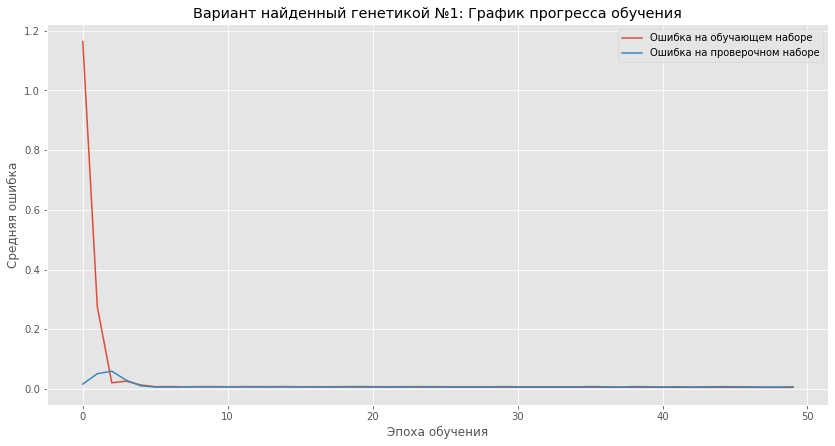

1/1 [==============================] - 0s 136ms/step


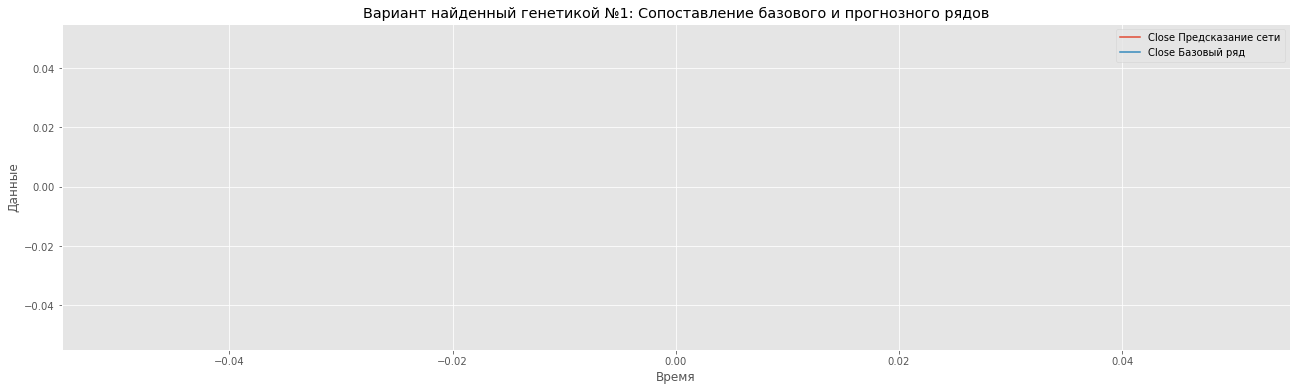

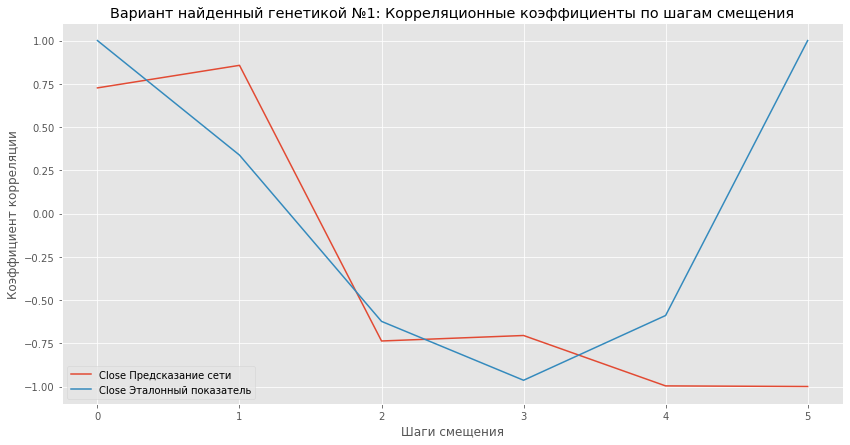

In [16]:
# Обучение модели на 200 эпохах
train_eval_net(model_v1, train_datagen, val_datagen, [(50, Adam(learning_rate=1e-4))],
               x_test, y_test, y_scaler, title='Вариант найденный генетикой №1')

In [20]:
from tensorflow.keras.models import load_model

In [20]:
model_v1.save('btc_model.h5')
print('Model Saved!')

Model Saved!


In [22]:
# load model
model=load_model('/Downloads/Untitled Folder 1/btc_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 1024)           6144      
                                                                 
 dense (Dense)               (None, 4, 16)             16400     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 23,073
Trainable params: 23,073
Non-trainable params: 0
_________________________________________________________________


In [23]:
y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test))

print(f'Цена биткоина завтра {y_pred_unscaled[0]}')

1/1 [==============================] - 0s 115ms/step
Цена биткоина завтра [19209.31]
